# 0.0. IMPORTS

In [1]:
import math
import warnings
import datetime
import inflection
import numpy                as np
import pandas               as pd
import seaborn              as sns

from matplotlib             import pyplot as plt
from IPython.core.display   import HTML
from IPython.display        import Image

## 0.1. Helper Functions

In [2]:
def jupyter_settings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Data

In [4]:
df_sales_raw = pd.read_csv('../datasets/train.csv', low_memory=False)
df_store_raw = pd.read_csv('../datasets/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0. DATA DESCRIPTION

In [5]:
# create copy df
df1 = df_raw.sample(50000).copy()

## 1.1. Rename Columns

In [6]:
cols_old = df1.columns

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

df1.columns = cols_new

## 1.2. Data Dimensions

In [7]:
print('Number of Rows: {}'. format(df1.shape[0]))
print('Number of Columns: {}'. format(df1.shape[1]))

Number of Rows: 50000
Number of Columns: 18


## 1.3. Data Types

In [8]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [9]:
df1.isna().sum()

store                               0
day_of_week                         0
date                                0
sales                               0
customers                           0
open                                0
promo                               0
state_holiday                       0
school_holiday                      0
store_type                          0
assortment                          0
competition_distance              129
competition_open_since_month    15884
competition_open_since_year     15884
promo2                              0
promo2_since_week               25143
promo2_since_year               25143
promo_interval                  25143
dtype: int64

## 1.5. Fillout NA

In [10]:
df1['competition_distance'].max()

75860.0

In [11]:
# # Verificando qual o método é mais rápido

# %timeit df1['competition_open_since_month'].apply(lambda x: math.isnan(x))
# %timeit df1['competition_open_since_month'].apply(lambda x: pd.isna(x))
# %timeit df1['competition_open_since_month'].apply(lambda x: np.isnan(x))

In [12]:
# ============================================================== competition_distance ==============================================================

# foi assumida a premissa que todos os valores faltantes de distancia do competidor se deve por conta
# do competidor mais proximo ser muito distante (bem maior que a distancia maxima)

# ===================== competition_distance =====================
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)


# ======================================================= competition_open_since_month/year // promo2_since_week/year =======================================================

# nessa substituicao para os valores faltantes iremos atribuir as datas de venda considerando que o
# tempo desde a a abertura de uma nova competicao ira impactar no aumento e/ou diminuicao das vendas

# ================= competition_open_since_month =================
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1).astype(np.int64())

# ================= competition_open_since_year ==================
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1).astype(np.int64())

# ======================= promo2_since_week ======================
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# ======================= promo2_since_year ======================
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)


# ================================================================= promo_interval =================================================================

# Substituimos os valores faltantes por 0, em seguida criamos uma coluna definindo se a venda 
# aconteceu no intervalo de promocao ou nao

month_map = {
     1: 'Jan',
     2: 'Feb',
     3: 'Mar',
     4: 'Apr',
     5: 'May',
     6: 'Jun',
     7: 'Jul',
     8: 'Aug',
     9: 'Sep',
    10: 'Oct',
    11: 'Nov',
    12: 'Dec'
}

df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']] \
                        .apply(lambda x: 0 if x['promo_interval'] == 0 else \
                                       1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [13]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types

In [14]:
df1 = df1.assign(
    competition_open_since_month = pd.to_numeric(df1['competition_open_since_month']),
    competition_open_since_year  = pd.to_numeric(df1['competition_open_since_year']),

    promo2_since_week = df1['promo2_since_week'].astype(np.int64()),
    promo2_since_year = df1['promo2_since_year'].astype(np.int64())
)

## 1.7. Descriptive Statistical

In [15]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [16]:
num_attributes = df1.select_dtypes(['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1. Numerical Attributes

In [17]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'standard', 'skew', 'kurtosis']

m

,attributes,min,max,range,mean,median,standard,skew,kurtosis
0,store,1.0,1115.0,1114.0,559.63664,560.0,321.442618,-0.005014,-1.194268
1,day_of_week,1.0,7.0,6.0,3.98920,4.0,1.998260,0.004875,-1.244762
2,sales,0.0,34692.0,34692.0,5803.77936,5771.0,3890.181985,0.688730,1.944774
3,customers,0.0,4985.0,4985.0,636.78464,612.0,470.379420,1.651572,7.222767
4,open,0.0,1.0,1.0,0.83042,1.0,0.375263,-1.761056,1.101362
5,promo,0.0,1.0,1.0,0.38066,0.0,0.485549,0.491582,-1.758418
6,school_holiday,0.0,1.0,1.0,0.17602,0.0,0.380837,1.701461,0.895004
7,competition_distance,20.0,200000.0,199980.0,5945.21600,2340.0,12507.830387,10.266313,148.677619
8,competition_open_since_month,1.0,12.0,11.0,6.77734,7.0,3.312335,-0.045217,-1.233276
9,competition_open_since_year,1900.0,2015.0,115.0,2010.31038,2012.0,5.546203,-7.224581,123.434252


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

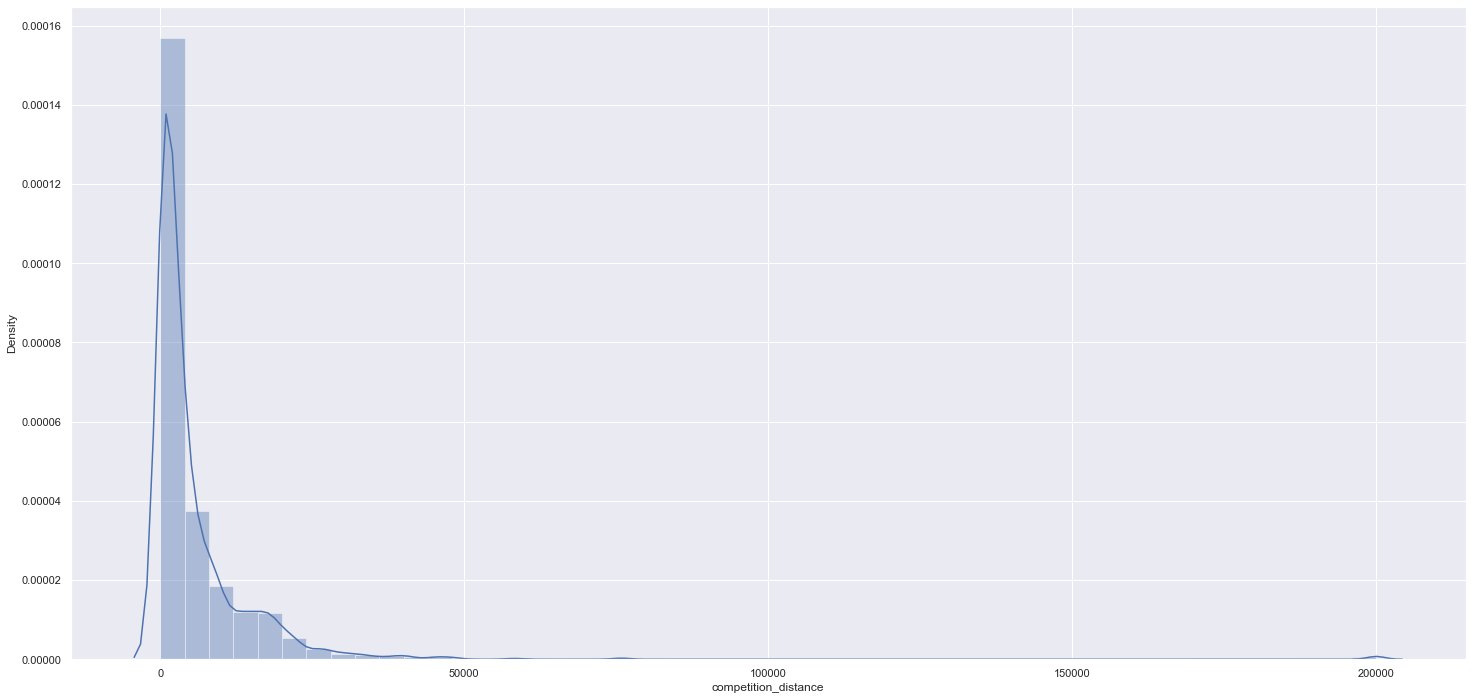

In [41]:
sns.distplot(df1['competition_distance'])

### 1.7.2. Categorical Attributes

In [19]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

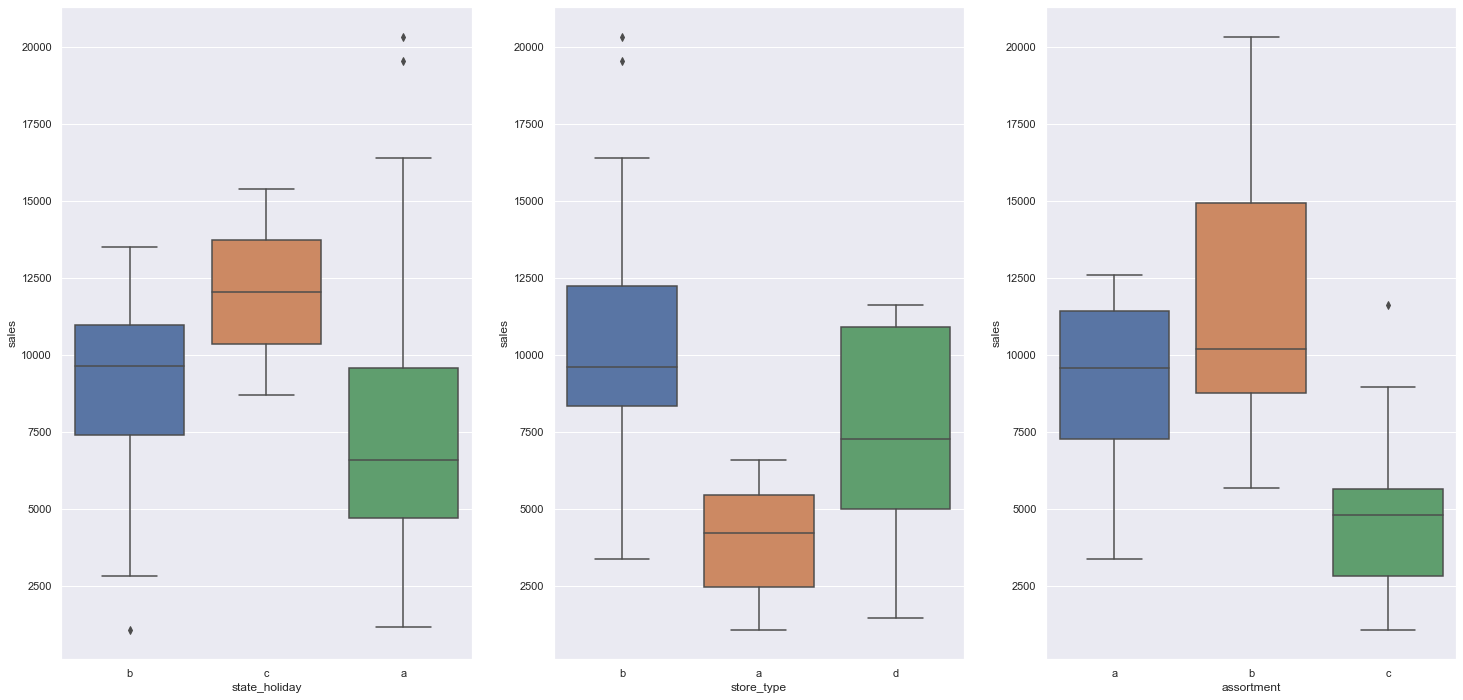

In [20]:
# Outlier = 3x desvio padrao

aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux)

# 2.0. FEATURE ENGINEERING

## 2.1. Mapa mental de hipoteses

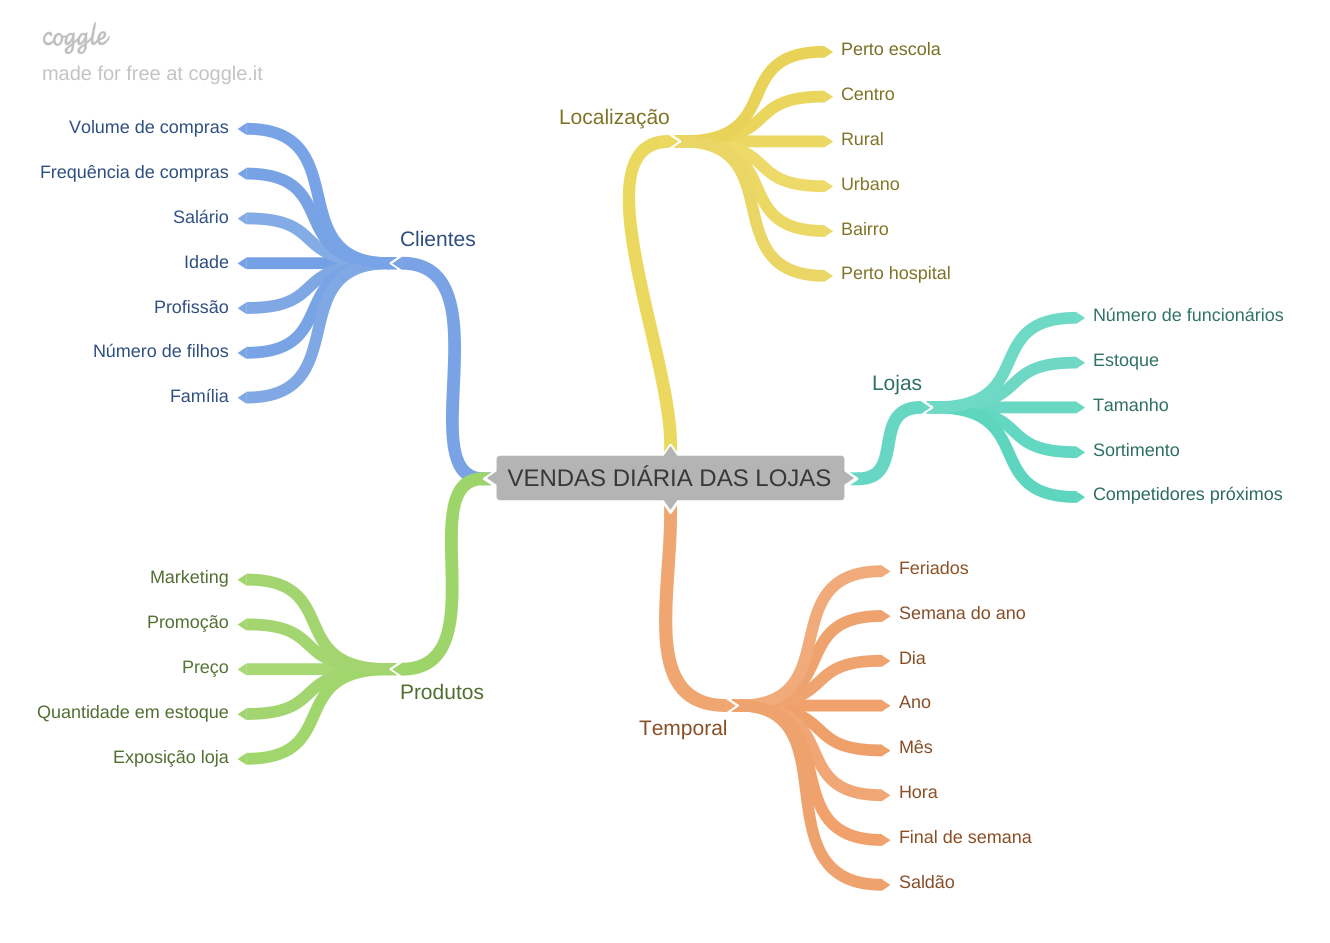

In [21]:
Image('../img/mapa_mental_hipoteses.png')

## 2.2. Criação das hipoteses

In [22]:
df2 = df1.copy()

### 2.2.1. Hipoteses Loja

**1.** Lojas com maior quadro de funcionarios deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais proximos deveriam vender menos.

**6.** Lojas com competidores a mais tempo deveriam vender mais.

### 2.2.2. Hipoteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposicao de produto deveriam vender mais.

**3.** Lojas com produtos com preco menor deveriam vender mais.

**4.** Lojas com promocoes mais agressivas (descontos maiores), deveriam vender mais.

**5.** Lojas com promocoes ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promocao deveriam vender mais.

**7.** Lojas com mais promocoes consecutivas deveriam vender mais.

### 2.2.3. Hipoteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mes.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.2. Lista Final de Hipóteses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais proximos deveriam vender menos.

**3.** Lojas com competidores a mais tempo deveriam vender mais.

**4.** Lojas com promocoes ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promocao deveriam vender mais.

**6.** Lojas com mais promocoes consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mes.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Feature Engineering

In [37]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'],
                                                                 month=x['competition_open_since_month'],
                                                                 day=1), axis=1)

df2['competition_time_month'] = ( ( df2['date'] - pd.to_datetime(df2['competition_since']) )/30 ).apply( lambda x: x.days ).astype( np.int64() )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(np.int64)

# assorment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

# 3.0. FILTRAGEM DE VARIÁVEIS

In [42]:
df3 = df2.copy()

In [43]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
532860,676,2,2014-03-11,6365,1667,1,0,regular_day,0,b,extended,1410.0,9,2008,0,11,2014,0,Mar,0,2014,3,11,11,2014-10,2008-09-01,67,2014-03-10,0
913670,156,3,2013-04-03,5459,646,1,0,regular_day,1,a,extended,2020.0,2,2011,1,14,2011,"Mar,Jun,Sept,Dec",Apr,0,2013,4,3,14,2013-13,2011-02-01,26,2011-03-28,105
730146,607,7,2013-09-15,0,0,0,0,regular_day,0,a,extended,350.0,8,1999,1,14,2011,"Jan,Apr,Jul,Oct",Sep,0,2013,9,15,37,2013-36,1999-08-01,171,2011-03-28,128
124616,852,6,2015-04-11,2671,340,1,0,regular_day,0,c,extended,940.0,4,2004,1,14,2011,"Jan,Apr,Jul,Oct",Apr,1,2015,4,11,15,2015-14,2004-04-01,134,2011-03-28,210
22357,58,6,2015-07-11,5524,480,1,0,regular_day,0,a,extended,7340.0,5,2008,1,27,2012,"Jan,Apr,Jul,Oct",Jul,1,2015,7,11,28,2015-27,2008-05-01,87,2012-06-25,158


## 3.1. Filtragem das linhas

In [46]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Seleção das colunas

In [48]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [49]:
df3.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
532860,676,2,2014-03-11,6365,0,regular_day,0,b,extended,1410.0,9,2008,0,11,2014,0,2014,3,11,11,2014-10,2008-09-01,67,2014-03-10,0
913670,156,3,2013-04-03,5459,0,regular_day,1,a,extended,2020.0,2,2011,1,14,2011,0,2013,4,3,14,2013-13,2011-02-01,26,2011-03-28,105
124616,852,6,2015-04-11,2671,0,regular_day,0,c,extended,940.0,4,2004,1,14,2011,1,2015,4,11,15,2015-14,2004-04-01,134,2011-03-28,210
22357,58,6,2015-07-11,5524,0,regular_day,0,a,extended,7340.0,5,2008,1,27,2012,1,2015,7,11,28,2015-27,2008-05-01,87,2012-06-25,158
695716,742,3,2013-10-16,5886,0,regular_day,0,d,extended,4380.0,10,2013,0,42,2013,0,2013,10,16,42,2013-41,2013-10-01,0,2013-10-14,0
